# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [18]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [2]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]


In [3]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [4]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220121.csv


In [5]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [6]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [7]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    return table2

In [8]:
df = prepare_df(raw_df)
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [9]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

7.380000000000001

In [10]:
def run_prob_weekly(simulate_prob):
    prior = np.array([1,1,1])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior * 50/prior.sum() + like * 50/like.sum()
        print(obj.data_pesquisa, posterior, simulate_prob(posterior))
        prior = posterior

run_prob_weekly(simulate_prob_freq)

2021-11-04 [38.88888889 27.77777778 33.33333333] 74.27
2021-11-06 [43.44444444 20.88888889 35.66666667] 81.44
2021-11-19 [39.17222222 17.14444444 43.68333333] 30.65
2021-11-20 [38.08611111 12.12222222 49.79166667] 10.040000000000001
2021-11-24 [36.21477273 10.60656566 53.17866162] 3.49
2021-11-29 [39.50738636  6.90328283 53.58933081] 7.380000000000001
2021-12-05 [42.75369318  9.45164141 47.7946654 ] 29.42
2021-12-09 [39.87684659 11.22582071 48.8973327 ] 17.169999999999998
2021-12-11 [41.3384233  13.26291035 45.39866635] 33.040000000000006
2021-12-13 [39.61921165 10.88145518 49.49933318] 14.399999999999999
2021-12-13 [43.80960582 12.44072759 43.74966659] 50.28
2021-12-16 [45.90480291 11.22036379 42.87483329] 62.17
2021-12-16 [44.73457967 11.55077596 43.71464437] 54.42
2021-12-21 [42.36728984 11.27538798 46.35732218] 32.73
2022-01-09 [44.14282859 11.76014297 44.09702844] 49.51
2022-01-12 [43.64004175 12.2526205  44.10733775] 47.870000000000005
2022-01-13 [42.52709158 11.68186581 45.79104

In [11]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,1955.000,535.000,1975.000,4465.0


In [12]:
def run_prob_monthly(simulate_prob):
    prior = np.array([1,1,1])
    posterior = np.array([0,0,0])
    df_by_mes = df.groupby("mes").sum().reset_index()
    for obj in df_by_mes.itertuples():
        # print(obj)
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior * 500/prior.sum() + like * 500/like.sum()
        print(obj.mes, posterior, simulate_prob(posterior))
        prior = posterior
run_prob_monthly(simulate_prob_freq)

2021_11 [369.11823638 217.11622822 413.7655354 ] 5.41
2021_12 [401.98880431 166.8907381  431.1204576 ] 15.290000000000001
2022_01 [419.91937416 143.35578338 436.72484246] 28.29


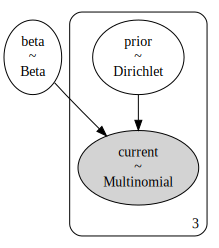

In [13]:
def build_model(prior, observed) -> pm.Model:
    observed = observed.astype("int32")
    with pm.Model() as dirichlet_model:
        beta = pm.Beta("beta", alpha=8, beta=1)
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=prior, shape=(3,),
        )

        pm.Multinomial(
            "current", n=observed.sum(), p=(previous_month_prior * beta), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [14]:
model.free_RVs

[beta_logodds__ ~ TransformedDistribution,
 prior_stickbreaking__ ~ TransformedDistribution]

In [22]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=10, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.sample_posterior_predictive(trace, 1000, progressbar=False)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(values, q=[0.03, 0.5, 0.97])

In [23]:
flat_prior = prior = np.array([1.0, 1.0, 1.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
# for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS])
    print(f">>> observed = {observed}")
    model = build_model(prior, observed)
    trace, ppc = sampling(model)
    posterior = ppc['current']
    # print(f">>> posterior.shape={posterior.shape}")
    prior = dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))
    # print('dirichlet.mle(posterior/posterior.sum(axis=1).reshape(-1, 1))=,', prior)
    print(">>> ", obj.mes, prior, calc_prob_lula_win(model, trace, ppc=ppc), "% <<<")
    # print(">>> ", obj.data_pesquisa, prior, calc_prob_lula_win(posterior), " <<<")



>>> observed = [6048.848 1507.332 7382.82 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, beta]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/10 [00:00<?, ?it/s]

/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


>>>  2021_11 [3006.22524107  748.12756684 3667.94426952] (0.0, 0.0) % <<<
>>> observed = [7356.516 1973.626 7586.858]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, beta]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/10 [00:00<?, ?it/s]

/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


>>>  2021_12 [4212.64628631 1107.55965486 4577.1041899 ] (0.0018181818181818182, 0.005749595745760689) % <<<
>>> observed = [1955.  535. 1975.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, beta]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/10 [00:00<?, ?it/s]

/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


>>>  2022_01 [1457.72322913  388.47899943 1548.72322497] (4.423636363636364, 0.4010729411618683) % <<<


In [32]:
values = np.random.normal(loc=10, scale=2, size=1000)
print(np.quantile(values, q=[0.03, 0.5, 0.97]))
print(values.mean(), values.std())

[ 6.50961213  9.94610193 13.74551899]
10.010595689515863 1.9528033378184413


In [ ]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [ ]:
az.summary(trace)

In [ ]:
#fig, ax = plt.subplots(2, figsize=(10,6))
az.plot_posterior({'Lula': ppc['current'][:,0], 'Demais': ppc['current'][:,2]})
#az.plot_posterior({}, ax=ax[1])

In [ ]:
def generate_data():
    intercept = 2
    x1 = np.random.random_sample(1)[0]
    true_coeff = -2
    theta = np.exp(intercept + true_coeff * x1)
    output = np.random.poisson(theta)

    return {'intercept': intercept, 'x1': x1, 'true_coeff': true_coeff, 'output': output, 'theta': theta}
generate_data()

In [ ]:
D1 = trace.posterior.prior.mean(axis=0).to_numpy()
D2 = dirichlet.mle(D1)
print(D2)
print(D2.sum())

In [ ]:
a0 = np.array([100, 299, 100])
D0 = np.random.dirichlet(a0, 1000)
D0

## DEZEMBRO

In [ ]:
# NOVEMBER
prior = pd.array([6049, 1508, 7382]).astype("float32")
# DECEMBER
observed = pd.array([7376, 1953, 7578])
                    
with pm.Model() as dirichlet_model:
        
    beta = pm.Beta("beta", alpha=4, beta=1)
    
    november_prior = pm.Dirichlet(
        "november_prior",
        # Lula, BrancosNulosNaoSabem, Demais candidatos
        a=prior * beta,
    )
    
    december_like = pm.Multinomial(
        "december_like", n=observed.sum(), p=november_prior, observed=observed,
    )
    

In [ ]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=2, return_inferencedata=False, cores=2, progressbar=False) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777,
   )
   az.plot_trace(dirichlet_trace)

In [ ]:
az.summary(dirichlet_trace)

In [ ]:
print(ppc)
ppc['december_like'].mean(axis=0)

In [ ]:
lula = ppc['december_like'][:, 0]
demais = ppc['december_like'][:, 2]
lula.shape,demais.shape

In [ ]:
(lula > demais).mean()

# Verifica conjugado

In [ ]:
# NOVEMBER
prior_data = pd.array([43, 11, 45]).astype("float32")
# DECEMBER
observed = pd.array([46, 12, 41])
                    
with pm.Model() as m:
        
    prior = pm.Dirichlet("prior", a=prior_data)
    
    pm.Multinomial("like", n=observed.sum(), p=prior, observed=observed)
    trace = pm.sample(5000, chains=2, return_inferencedata=True, cores=2, progressbar=False) # 20K samples

In [ ]:
az.summary(trace)

In [ ]:
obs2 = prior_data + observed
with pm.Model() as m2:
        
    prior = pm.Dirichlet("prior", a=np.array([1.0, 1.0, 1.0]))
    
    pm.Multinomial("like", n=obs2.sum(), p=prior, observed=obs2)
    trace2 = pm.sample(5000, tune=2000, chains=2, return_inferencedata=True, cores=2, progressbar=False) # 20K samples

In [ ]:
az.summary(trace2)

# Janeiro/Dezembro

In [ ]:
import numpy as np

T1 = 2_000 # 
T2 = 1_500 # EXAME/IDEIA
T3 = 1_000 # XP/IPESPE
# Mês atual: Lula, BrancosNulosNaoSabem, Demais candidatos
current_observed = np.array([1955, 535, 2010])

print(current_observed.sum())

december_data = np.array([7356, 1973, 7578]).astype("float32")

with pm.Model() as dirichlet_model:
    
    beta = pm.Beta("beta", alpha=6, beta=1)
    
    december_prior = pm.Dirichlet(
        "prior",
        # Mes anterior: Lula, BrancosNulosNaoSabem, Demais candidatos
        a = december_data * beta,
        # a = [1.0,1.0,1.0],
        shape=(3,),
    )
    
    january_like = pm.Multinomial(
        "like", n=current_observed.sum(), p=december_prior, observed=current_observed, shape=(3,)
    )
pm.model_to_graphviz(dirichlet_model)    

In [ ]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=4, return_inferencedata=True, cores=4, progressbar=False) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777
   )
   az.plot_trace(dirichlet_trace, figsize=(22,8))
   dirichlet_trace.extend(az.from_dict(posterior_predictive=ppc))

In [ ]:
az.summary(dirichlet_trace)

In [ ]:
az.plot_posterior(dirichlet_trace);

In [ ]:
az.plot_energy(dirichlet_trace)

In [ ]:
lula = ppc['like'][:, 0]
demais = ppc['like'][:, 2]
print(lula.shape,demais.shape)
prob_lula = (lula > demais).mean() * 100.0
print(f"Probabilidade de Lula vencer no primeiro turno é de: {prob_lula:.2f}%", )

In [ ]:
# create figure and axes
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.set_xlim(1800, 2200)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=500);

## Playground

In [ ]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

In [ ]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [ ]:
observed.sum(axis=1)

In [ ]:
current_observed.sum(axis=0)

In [ ]:
current_observed.sum(axis=1)

In [ ]:
current_observed

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

df = px.data.gapminder()
px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [ ]:
# hide_input
# This cell is required for the export to HTML to work.


In [ ]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

In [ ]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


In [ ]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [ ]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

In [ ]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

In [ ]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [ ]:
dir2

In [ ]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

In [ ]:
np.arange(10)

In [ ]:
np.linspace(0,1, 101)

In [ ]:
x = np.arange(5,10)

In [ ]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])